# Contrastive Language-Image Pre-Training (CLIP) 

It is a model that generates embedding for both images and texts.

Trained with dataset of 400 million {text, image} pairs collected from the internet trying to cover as many visual concepts as possible. It attempts to create a representation for both image and corresponding captions, using an encoder (transformer model) for each of the two data types.

Below we use the CLIP model to correspond some captions with the given images and understand how we can create a multi model that takes both texts and images into account, processes both of them and tries to provide as accurate result as possible. 

In [1]:
from transformers import CLIPTokenizerFast, CLIPProcessor, CLIPModel
import matplotlib.pyplot as plt
import numpy as np
import torch
import seaborn as sns
from PIL import Image

/home/sajalpaudyal/Documents/Programming_Works/AI_agents_with_LLMs/lib64/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
model_name = "openai/clip-vit-base-patch32"
tokenizer = CLIPTokenizerFast.from_pretrained(model_name)
processor = CLIPProcessor.from_pretrained(model_name)
model = CLIPModel.from_pretrained(model_name)


Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


In [3]:
captions = [
    "a red apple",
    "a sparrow on a branch",
    "sunset down the horizon",
    "a human primate cuter than all humans possible"
]

In [4]:
fs_images = [
    "../images/apple.jpg",
    "../images/sparrow.jpg",
    "../images/sunset.jpg",
    "../images/test_monkey.jpg",
]

In [5]:
caption_embeddings = []

for caption in captions:
    inputs = tokenizer(caption, return_tensors="pt")
    text_embedding = model.get_text_features(**inputs)
    text_embedding /= text_embedding.norm(dim=1, keepdim=True)
    caption_embeddings.append(text_embedding.detach().cpu().numpy())

In [7]:
image_embeddings = []
images = []

for single_image in fs_images:
    image = Image.open(single_image).convert("RGB")
    images.append(image)
    
    processed_image = processor(text=None, images=image, return_tensors="pt")["pixel_values"]
    image_embedding = model.get_image_features(pixel_values=processed_image)
    image_embedding /= image_embedding.norm(dim = -1, keepdim=True)
    image_embeddings.append(image_embedding.detach().cpu().numpy())
    
    
caption_embeddings = np.vstack(caption_embeddings)
image_embeddings = np.vstack(image_embeddings)
    

In [8]:
similarity_score = np.dot(caption_embeddings, image_embeddings.T)

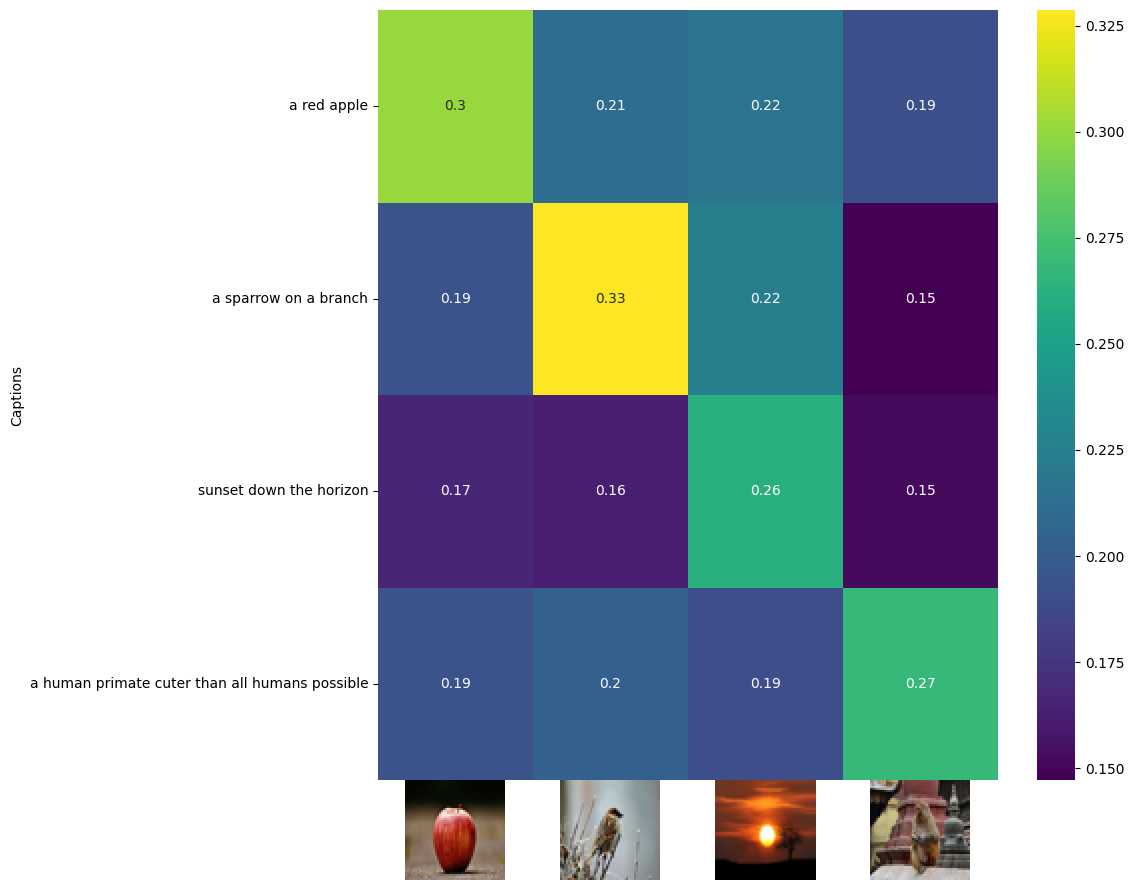

In [10]:
plt.figure(figsize=(10, 10))
ax = sns.heatmap(similarity_score, annot=True, xticklabels=["Image " + str(i) for i in range(len(fs_images))], yticklabels=captions, cmap="viridis")
plt.xlabel("")
plt.ylabel("Captions")


for i, image in enumerate(images):
    img = image.resize((50,50))
    img = np.array(img)
    x_offset = (i + 0.5) * (ax.get_position().width / len(images)) + ax.get_position().x0 - 0.05  
    y_offset = ax.get_position().y0 - 0.1  
    sub_ax = ax.figure.add_axes([x_offset, y_offset, 0.1, 0.1], anchor='C', zorder=1)
    sub_ax.imshow(img)
    sub_ax.axis('off')
    
plt.show()
    